# HW5: The carry trade based on GBP

$\textbf{recap carry trade strategies: }$

Those strategies consist in holding positions that make money most of cases (when nothing particular happens) but lose money during tail events. 

This is called carry trade because the portfolio carry the risk of those tail events. Risk comes from a decline in the value of our position, and profits comes from appreciation of them


$\textbf{Definition of carry trade: }$ we are given a time series $r_i$ of returns related to our strategy that should satisfy:

1. Positive returns most of the times (usually small postive returns most of times, and the rest is large negative returns)

2. Negative skewness (fatter left tail, associated to highly negative returns for extrem events)

3. The returns are correlated to broad market indicators, i.e: when positive/optimistic market indicators, the strategy should perform, and vice versa

4. Returns are negatively correlated to fear indicators (such as VIX), i.e perform well in low volatility regimes (stable environment) and perfom badly in high volatility regimes.

5. High level kurtosis for the return distribution, meaning the returns distribution should have a fatter tails than normal distribution.


$\textbf{Main issue with this strategy: }$ 

1. The investors hope that the occasional loss will be small enough to continue and make money in the long run (not like LTCM)

2. As previously explained, the returns are very correlated to the market performance, which is not attractive because this strategy does not help diversifying (it will loose money when the market is doing bad)

$\textbf{Application to FX carry strategy: }$ 

The strategy is to borrow money from low-interest-rates currency (usually from unstable countries) while lending it in another currency that has a higher interest rates (more stable country)

In [1]:
## Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl 
import functools
import seaborn as sns
import os
import datetime
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import plotnine as p9

import h5py
from IPython.display import display

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Get data

We need to get the shortest avaible maturity rates for UK OIS (overnight index swaps), with the corresponding spot FX rates of dollar vs pound. More, we get swap yield curves and FX rates of the following currencies: Turkish lira, pakistanese rupee, costa rican colon, south american rand (from the earliest date available to now).

The $\textbf{UK OIS}$ are contracts where two 2 parties agree to exchange $\textbf{(swap) a fixed predetermined interest rate}$, for a $\textbf{floating rate}$ linked to an overnight interest rate index (SONIA: Sterling Overnight Index Average) over a specific period. SONIA is the average interest rates banks pay to borrow sterling overnight in the unsecured market. This is a $\textbf{robust and reliable benchmark for overnight interest rates in the UK}$ (overnight rates are usually the lowest interest rates because it is usually one big instituation like a bank that borrows/lends to another big instituation => the most creditworthy). $\textbf{OIS maturities}$ range from overnight to several years. We will get the shortests. 

$\textbf{What are UK OIS used for? }$ Benchmark for interest rates, hedging tool; indicator of market stress (check spread with LIBOR)

The $\textbf{spot FX rates dollar vs pound}$ is the current rate of change for 1 dollar vs 1 pound

### suggestion from class

for any country (but mostly pakistan) if there is a long time of missing data (where therefore not relevant to forwardfill), just ignore these dates and do not trade during those dates

use the swap curves to price bonds on both entry and exit prices.

we buy 5 years bond but sell them a week later so that we dont have to take into account the coupons. There are 3 sources of income from this strategy: theta (if nothing changes, the price of the coupon increases by time), the change for rates and the change of currency value

### UK OIS data

In [2]:
# OIS_2009_2015 = pd.read_excel('C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/QTS/OIS_data/OIS daily data_2009 to 2015.xlsx', sheet_name='2. spot curve', header=2)
# OIS_2009_2015 = OIS_2009_2015.drop([0,1])

# OIS_2016_2024 = pd.read_excel('C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/QTS/OIS_data/OIS daily data_2016 to 2024.xlsx', sheet_name='4. spot curve', header=2)
# OIS_2016_2024 = OIS_2016_2024.drop([0,1])

# OIS_2025_pres = pd.read_excel('C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/QTS/OIS_data/OIS daily data_2025 to present.xlsx', sheet_name='4. spot curve', header=2)
# OIS_2025_pres = OIS_2025_pres.drop([0,1])

# OIS_data = pd.concat([OIS_2009_2015, OIS_2016_2024, OIS_2025_pres], axis=0)
# OIS_data.columns


with API using the Bank_of_England_Data_Fetch notebook

DATE        object
IUDSOIA    float64
IUDSNPY    float64
dtype: object


,Tenor,date,Rate
0,SONIA,2000-01-04,4.5910
1,SONIA,2000-01-05,4.4584
2,SONIA,2000-01-06,4.9208
3,SONIA,2000-01-07,4.4172
4,SONIA,2000-01-10,4.2968
...,...,...,...
12687,5Y,2025-02-06,4.0430
12688,5Y,2025-02-07,4.0302
12689,5Y,2025-02-10,4.0411
12690,5Y,2025-02-11,4.1024


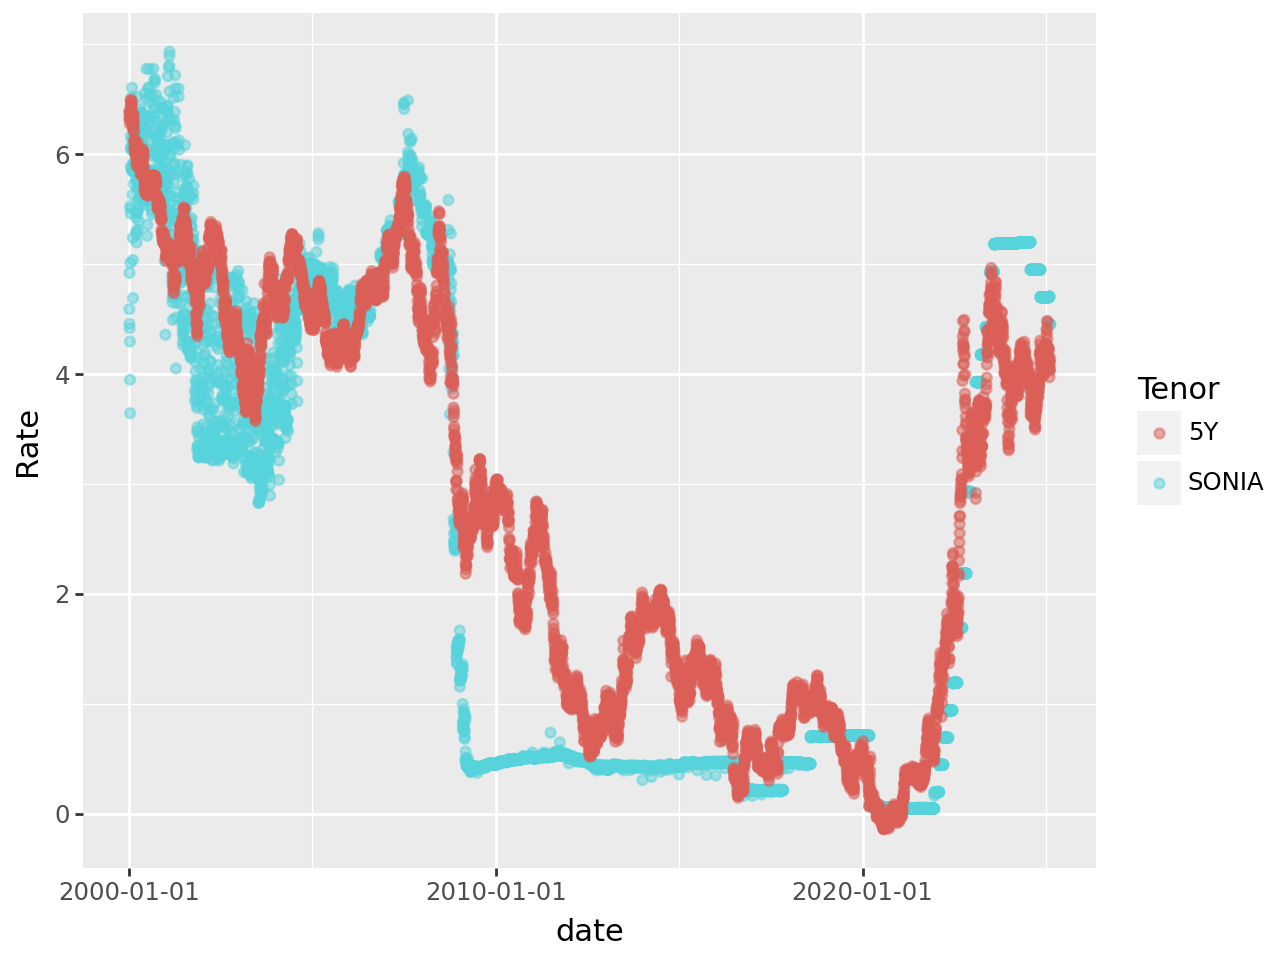

In [3]:
import io
import requests
from IPython.display import display


daily_sonia_series_name = 'IUDSOIA'
treas_5_yr_nominal_par_yld = 'IUDSNPY'
treas_10_yr_nominal_par_yld = 'IUDMNPY'
treas_20_yr_nominal_par_yld = 'IUDLNPY'

yesterday = datetime.date.today() - datetime.timedelta(days=1)

yesterday_str = yesterday.strftime('%d/%b/%Y')
beng_url_endpoint = 'http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes'
beng_headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) '
                  'AppleWebKit/537.36 (KHTML, like Gecko) '
                  'Chrome/54.0.2840.90 '
                  'Safari/537.36'
}
beng_payload_generic = {
    'Datefrom'   : '01/Jan/2000',
    'Dateto'     : yesterday_str,
    'CSVF'       : 'TN',
    'UsingCodes' : 'Y',
    'VPD'        : 'Y',
    'VFD'        : 'N'
}

series_codes = ','.join([
        
        daily_sonia_series_name, 
        treas_5_yr_nominal_par_yld,
        
    ])
series_codes

specific_payload = {'SeriesCodes':series_codes}
specific_payload.update( beng_payload_generic )

response = requests.get(
    beng_url_endpoint, 
    params=specific_payload, 
    headers=beng_headers)

assert str(response.status_code)=='200'

beng_df = pd.read_csv(io.BytesIO(response.content))
print(beng_df.dtypes)
beng_df['date'] = pd.to_datetime(beng_df['DATE'])
beng_df.rename(columns={daily_sonia_series_name:'SONIA', treas_5_yr_nominal_par_yld:'5Y'}, inplace=True)
del beng_df['DATE']
beng_df.set_index('date', inplace=True)
beng_df.iloc[[0,1,2,-3,-2,-1]]

beng_plt_df = beng_df.unstack().reset_index().rename(columns={'level_0':'Tenor', 0:'Rate'})
display(beng_plt_df)
ggplt = (
    p9.ggplot(beng_plt_df, p9.aes(x='date', y='Rate', color='Tenor'))
    + p9.geom_point(alpha=0.5)
)
display(ggplt)

In [4]:
## print number missing days of data per year
def missing_days_per_year(df):
    years = df['date'].dt.year.unique()
    missing_counts = {}

    for year in years:
        date_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='B')  # Business days only
        available_dates = df[df['date'].dt.year == year]['date'].unique()
        missing_dates = set(date_range) - set(available_dates)
        missing_counts[year] = len(missing_dates)

    return missing_counts

missing_days_OIS = missing_days_per_year(beng_plt_df[ beng_plt_df['Tenor']=='SONIA' ])
missing_days_5Y = missing_days_per_year(beng_plt_df[ beng_plt_df['Tenor']=='5Y' ])
print(missing_days_OIS, '\n', missing_days_5Y)

{2000: 8, 2001: 8, 2002: 9, 2003: 8, 2004: 8, 2005: 8, 2006: 8, 2007: 8, 2008: 8, 2009: 8, 2010: 8, 2011: 9, 2012: 9, 2013: 8, 2014: 8, 2015: 8, 2016: 8, 2017: 8, 2018: 8, 2019: 8, 2020: 8, 2021: 8, 2022: 10, 2023: 9, 2024: 8, 2025: 231} 
 {2000: 8, 2001: 8, 2002: 9, 2003: 8, 2004: 8, 2005: 8, 2006: 8, 2007: 8, 2008: 8, 2009: 8, 2010: 8, 2011: 9, 2012: 9, 2013: 8, 2014: 8, 2015: 8, 2016: 8, 2017: 8, 2018: 8, 2019: 8, 2020: 8, 2021: 8, 2022: 10, 2023: 9, 2024: 8, 2025: 231}


### Commentary

SONIA represents the market expectations of the BoE policy rate over the swap horizon, while UK 5Y nominal par yield represents the market yield for UK government bonds maturing in 5 years

In normal economic environment, the 5Y yield should be higher than OIS due to the term premium. However, during crisis the spread is lower (or even reverts) due to the demand for stability (ppl want bonds with longer term)

We can see that the overnight and the 5Y rates follow the same trend overall because they are related to the country's economic stability and monetary policies.

They were high during 2010-2020 because of the high interest rate environment. Then SONIA dropped drastically after 2008 crisis, and 5Y rates followed more smoothly (because SONIA represents the market expectations of short term rates while the 5Y also accounts for inflation expectations). After 2020, the inflation and rates increased, which implied that both rates went up

### Get FX spot rates

In [5]:
API_key = 'CazLxm9XJ7CzL3g8prJm'
quandl.ApiConfig.api_key = API_key

def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(r"C:\Users\benja\OneDrive\Bureau\UchicagoMSFM\QTS" , "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print('hello')
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=API_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

### Get data and pre-process

In [6]:
fx_data = fetch_quandl_table('EDI/CUR', avoid_download=False)

## list tickers 
list_tickers = ['GBP','TRY', 'PKR', 'CRC', 'ZAR']
fx_data = fx_data[fx_data['code'].isin(list_tickers)]
fx_data['date'] = pd.to_datetime(fx_data['date'])
## sort data by date
fx_data = fx_data.sort_values(by='date')
fx_data = fx_data.pivot(index='date', columns='code', values='rate').reset_index()    

display(fx_data)


Data file C:\Users\benja\OneDrive\Bureau\UchicagoMSFM\QTS\quandl_data_table_downloads\EDI/CUR_20250214.zip size 7929830 exists already, no need to download


code,date,CRC,GBP,PKR,TRY,ZAR
0,2000-01-01,NaN,0.618877,NaN,NaN,6.158155
1,2000-01-02,NaN,0.618877,NaN,NaN,6.158155
2,2000-01-03,NaN,0.614647,NaN,0.543175,6.134985
3,2000-01-04,NaN,0.610927,NaN,0.535527,6.103728
4,2000-01-05,NaN,0.609433,NaN,0.536239,6.070312
...,...,...,...,...,...,...
9165,2025-02-10,513.145836,0.806360,280.934663,36.023557,18.526500
9166,2025-02-11,510.383840,0.808888,279.631579,36.021201,18.426657
9167,2025-02-12,506.922792,0.803514,279.000000,36.056300,18.513850
9168,2025-02-13,504.932934,0.800470,278.532172,36.113401,18.461255


### Show the curves and their correlation

In [7]:
fx_gbp = fx_data[['date','GBP']].dropna().rename(columns={'GBP':'rate'})
fx_try = fx_data[['date','TRY']].dropna().rename(columns={'TRY':'rate'})
fx_pkr = fx_data[['date','PKR']].dropna().rename(columns={'PKR':'rate'})
fx_crc = fx_data[['date','CRC']].dropna().rename(columns={'CRC':'rate'})
fx_zar = fx_data[['date','ZAR']].dropna().rename(columns={'ZAR':'rate'})
display(fx_zar)

code,date,rate
0,2000-01-01,6.158155
1,2000-01-02,6.158155
2,2000-01-03,6.134985
3,2000-01-04,6.103728
4,2000-01-05,6.070312
...,...,...
9165,2025-02-10,18.526500
9166,2025-02-11,18.426657
9167,2025-02-12,18.513850
9168,2025-02-13,18.461255


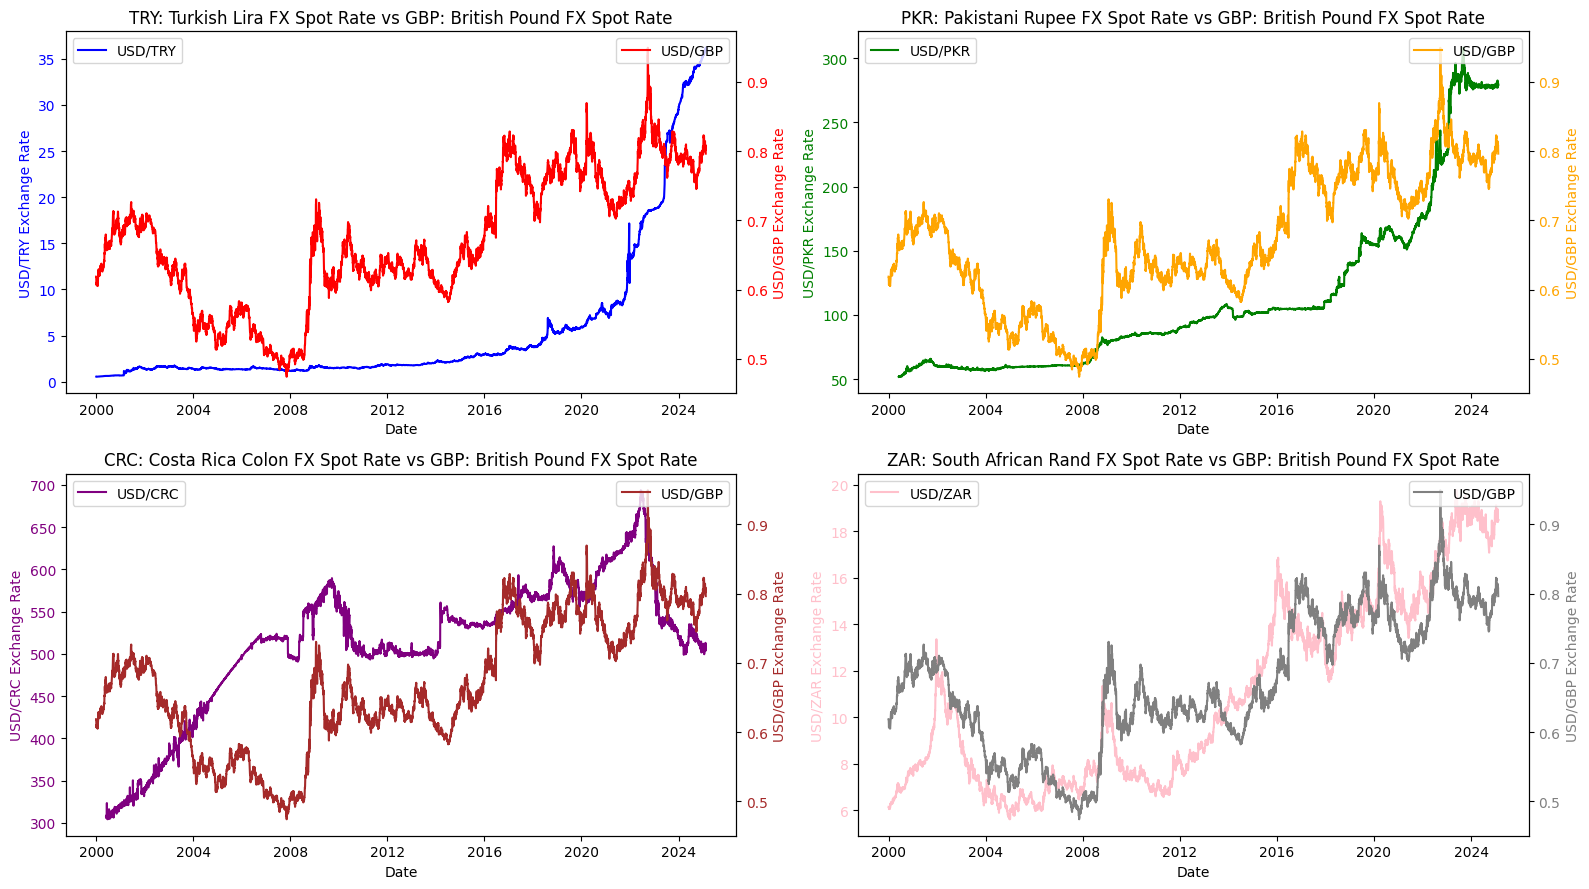

code,date,CRC,GBP,PKR,TRY,ZAR
code,,,,,,
date,1.000000,0.794055,0.710453,0.865107,0.702552,0.872130
CRC,0.794055,1.000000,0.366576,0.496227,0.278679,0.519121
GBP,0.710453,0.366576,1.000000,0.732784,0.603125,0.853670
PKR,0.865107,0.496227,0.732784,1.000000,0.938340,0.878529
TRY,0.702552,0.278679,0.603125,0.938340,1.000000,0.759190
ZAR,0.872130,0.519121,0.853670,0.878529,0.759190,1.000000


In [8]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

# Subplot 1: USD/TRY vs USD/GBP
ax[0, 0].plot(fx_try['date'], fx_try['rate'], label='USD/TRY', color='blue')
ax[0, 0].set_xlabel("Date")
ax[0, 0].set_ylabel("USD/TRY Exchange Rate", color='blue')
ax[0, 0].tick_params(axis='y', labelcolor='blue')

ax2_00 = ax[0, 0].twinx()
ax2_00.plot(fx_gbp['date'], fx_gbp['rate'], label='USD/GBP', color='red')
ax2_00.set_ylabel("USD/GBP Exchange Rate", color='red')
ax2_00.tick_params(axis='y', labelcolor='red')

ax[0, 0].set_title('TRY: Turkish Lira FX Spot Rate vs GBP: British Pound FX Spot Rate')
ax[0, 0].legend(loc='upper left')
ax2_00.legend(loc='upper right')

# Subplot 2: USD/PKR vs USD/GBP
ax[0, 1].plot(fx_pkr['date'], fx_pkr['rate'], label='USD/PKR', color='green')
ax[0, 1].set_xlabel("Date")
ax[0, 1].set_ylabel("USD/PKR Exchange Rate", color='green')
ax[0, 1].tick_params(axis='y', labelcolor='green')

ax2_01 = ax[0, 1].twinx()
ax2_01.plot(fx_gbp['date'], fx_gbp['rate'], label='USD/GBP', color='orange')
ax2_01.set_ylabel("USD/GBP Exchange Rate", color='orange')
ax2_01.tick_params(axis='y', labelcolor='orange')

ax[0, 1].set_title('PKR: Pakistani Rupee FX Spot Rate vs GBP: British Pound FX Spot Rate')
ax[0, 1].legend(loc='upper left')
ax2_01.legend(loc='upper right')

# Subplot 3: USD/CRC vs USD/GBP
ax[1, 0].plot(fx_crc['date'], fx_crc['rate'], label='USD/CRC', color='purple')
ax[1, 0].set_xlabel("Date")
ax[1, 0].set_ylabel("USD/CRC Exchange Rate", color='purple')
ax[1, 0].tick_params(axis='y', labelcolor='purple')

ax2_10 = ax[1, 0].twinx()
ax2_10.plot(fx_gbp['date'], fx_gbp['rate'], label='USD/GBP', color='brown')
ax2_10.set_ylabel("USD/GBP Exchange Rate", color='brown')
ax2_10.tick_params(axis='y', labelcolor='brown')

ax[1, 0].set_title('CRC: Costa Rica Colon FX Spot Rate vs GBP: British Pound FX Spot Rate')
ax[1, 0].legend(loc='upper left')
ax2_10.legend(loc='upper right')

# Subplot 4: USD/ZAR vs USD/GBP
ax[1, 1].plot(fx_zar['date'], fx_zar['rate'], label='USD/ZAR', color='pink')
ax[1, 1].set_xlabel("Date")
ax[1, 1].set_ylabel("USD/ZAR Exchange Rate", color='pink')
ax[1, 1].tick_params(axis='y', labelcolor='pink')

ax2_11 = ax[1, 1].twinx()
ax2_11.plot(fx_gbp['date'], fx_gbp['rate'], label='USD/GBP', color='gray')
ax2_11.set_ylabel("USD/GBP Exchange Rate", color='gray')
ax2_11.tick_params(axis='y', labelcolor='gray')

ax[1, 1].set_title('ZAR: South African Rand FX Spot Rate vs GBP: British Pound FX Spot Rate')
ax[1, 1].legend(loc='upper left')
ax2_11.legend(loc='upper right')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()



## show correlation matrix
import seaborn as sns

corr = fx_data.corr()
# sns.heatmap(corr, annot=True, cmap='coolwarm')
# plt.show()
display(corr)


### Commentary

1. FX rates curves:

a. Turkie: sharp increase after 2018 of fx spot rates (meaning depreciation of the Lira). Particularly sharp during 2021-2024. This can be explained with Turkish economy: economic crisis, high inflation, monetary policies (keeping interest rates low despite inflation)

b. Pakistan: continuous depreciation from 2008 to 2021 followed by sharpe decline of the money value. This is due to economic crisis, high inflation, political instability

c. Costa Rican : A long-term appreciation followed by a volatile period after 2010. The fluctuations likely correspond to economic reforms, trade balance shifts, and capital flows.

d. South Africa: Shows high volatility, with peaks around 2002, 2008, and after 2015. ZAR is highly sensitive to commodity prices, global risk sentiment, and local political instability.

e. Great Britain: Exhibits relative stability but with notable dips, particularly during the 2008 financial crisis and post-Brexit referendum (2016). It remains influenced by interest rate decisions and global market risk


2. Correlation

a. PKR & TRY (0.94): High correlation suggests common external pressures, such as inflation, capital outflows, and dependence on external debt.

b. ZAR & GBP (0.85): This could be driven by historical trade relations and commodity price impacts.

c. CRC & GBP (0.37): Weak correlation likely due to different economic structures, with Costa Rica being more tied to Latin American trade rather than global financial markets.

d. ZAR & PKR (0.88): Both economies are emerging markets with exposure to commodity price fluctuations and external financing risks.

let's check the number of missing days

In [9]:
missing_days_fx_gbp = missing_days_per_year(fx_gbp)
missing_days_fx_try = missing_days_per_year(fx_try)
missing_days_fx_pkr = missing_days_per_year(fx_pkr)
missing_days_fx_crc = missing_days_per_year(fx_crc)
missing_days_fx_zar = missing_days_per_year(fx_zar)
print(missing_days_fx_gbp, '\n', missing_days_fx_try, '\n', missing_days_fx_pkr, '\n', missing_days_fx_crc, '\n', missing_days_fx_zar)

{2000: 0, 2001: 0, 2002: 0, 2003: 0, 2004: 0, 2005: 0, 2006: 0, 2007: 0, 2008: 0, 2009: 0, 2010: 0, 2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0, 2019: 0, 2020: 0, 2021: 0, 2022: 0, 2023: 0, 2024: 0, 2025: 228} 
 {2000: 5, 2001: 7, 2002: 6, 2003: 6, 2004: 3, 2005: 0, 2006: 0, 2007: 0, 2008: 0, 2009: 0, 2010: 0, 2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0, 2019: 0, 2020: 0, 2021: 0, 2022: 0, 2023: 0, 2024: 0, 2025: 228} 
 {2000: 107, 2001: 0, 2002: 0, 2003: 0, 2004: 0, 2005: 0, 2006: 0, 2007: 0, 2008: 0, 2009: 0, 2010: 0, 2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0, 2019: 0, 2020: 0, 2021: 0, 2022: 0, 2023: 1, 2024: 0, 2025: 228} 
 {2000: 107, 2001: 0, 2002: 0, 2003: 0, 2004: 0, 2005: 0, 2006: 0, 2007: 0, 2008: 0, 2009: 0, 2010: 0, 2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0, 2019: 0, 2020: 0, 2021: 0, 2022: 0, 2023: 1, 2024: 0, 2025: 228} 
 {2000: 0, 2001: 0, 2002: 0, 2003: 0, 200

## Get Swap Yield Curves



In [10]:
yc_data = pd.read_table('C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/QTS/Swap_Yield_Curves/InferredYieldCurves_2025-02-04.tab', index_col=0)
list_shortnames  = ['Rep Turkey','Rep South Africa','Islamic Rep Pakistan', 'Rep Costa Rica']
yc_data = yc_data[yc_data['shortname'].isin(list_shortnames)] #
yc_data['date'] = pd.to_datetime(yc_data['date'])
yc_data = yc_data.sort_values(by='date').reset_index().drop(columns='index')

## rename maturities in floats
# yc_data.loc[:, 'tenor'] = yc_data['tenor'].apply(lambda x: x.replace('Y', ''))
# yc_data.loc[:, 'tenor'] = yc_data['tenor'].apply(lambda x: x.replace('6M', '0.5'))
# yc_data.loc[:, 'tenor'] = yc_data['tenor'].astype(float)
set(yc_data['tenor'].values)

{'10Y', '1Y', '5Y', '6M'}

### format swap yield curves data

In [72]:
yc_6M = yc_data[yc_data['tenor']=='6M']
yc_6M = yc_6M[['date','yield','shortname']].pivot(index='date', columns='shortname', values='yield').reset_index()

yc_1Y = yc_data[yc_data['tenor']=='1Y']
yc_1Y = yc_1Y[['date','yield','shortname']].pivot(index='date', columns='shortname', values='yield').reset_index()

yc_5Y = yc_data[yc_data['tenor']=='5Y']
yc_5Y = yc_5Y[['date','yield','shortname']].pivot(index='date', columns='shortname', values='yield').reset_index()

yc_10Y = yc_data[yc_data['tenor']=='10Y']
yc_10Y = yc_10Y[['date','yield','shortname']].pivot(index='date', columns='shortname', values='yield').reset_index()

display(yc_6M)

shortname,date,Islamic Rep Pakistan,Rep Costa Rica,Rep South Africa,Rep Turkey
0,2010-01-04,0.116467,0.011485,0.009400,0.010601
1,2010-01-05,0.116367,0.007155,0.008233,0.010034
2,2010-01-06,0.116167,0.006760,0.008736,0.009991
3,2010-01-07,0.075267,0.006860,0.008222,0.010218
4,2010-01-08,0.075167,0.006565,0.007713,0.009627
...,...,...,...,...,...
3930,2025-01-29,0.123677,0.098908,0.049312,0.052674
3931,2025-01-30,0.123745,0.098910,0.049189,0.052313
3932,2025-01-31,0.123845,0.099005,0.049391,0.052177
3933,2025-02-03,0.125311,0.099045,0.049203,0.052303


check for missing days

In [12]:
missing_days_yc_try = missing_days_per_year(yc_data[ yc_data['shortname']=='Rep Turkey' ])
missing_days_yc_zar = missing_days_per_year(yc_data[ yc_data['shortname']=='Rep South Africa' ])
missing_days_yc_pkr = missing_days_per_year(yc_data[ yc_data['shortname']=='Islamic Rep Pakistan' ])
missing_days_yc_crc = missing_days_per_year(yc_data[ yc_data['shortname']=='Rep Costa Rica' ])
print(missing_days_yc_try, '\n', missing_days_yc_zar, '\n', missing_days_yc_pkr, '\n', missing_days_yc_crc)

{2010: 1, 2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0, 2019: 0, 2020: 0, 2021: 0, 2022: 0, 2023: 0, 2024: 2, 2025: 236} 
 {2010: 1, 2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0, 2019: 0, 2020: 0, 2021: 0, 2022: 0, 2023: 0, 2024: 2, 2025: 236} 
 {2010: 87, 2011: 0, 2012: 1, 2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0, 2019: 0, 2020: 7, 2021: 4, 2022: 23, 2023: 7, 2024: 113, 2025: 236} 
 {2010: 2, 2011: 3, 2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0, 2019: 0, 2020: 0, 2021: 0, 2022: 0, 2023: 0, 2024: 2, 2025: 236}


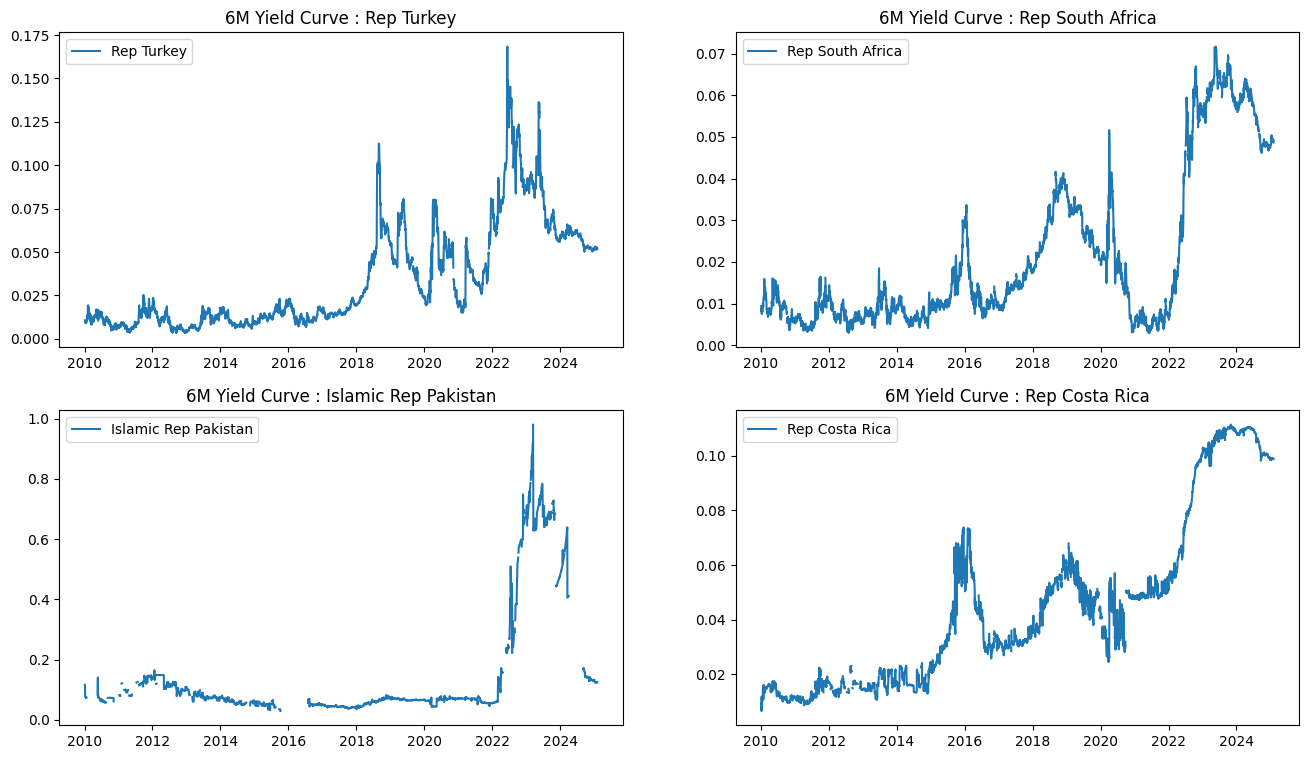

In [13]:
## plot 6M maturity yield curves


fig, ax = plt.subplots(2,2, figsize=(16,9))

ax[0,0].plot(yc_6M['date'], yc_6M['Rep Turkey'], label='Rep Turkey')
ax[0,0].set_title('6M Yield Curve : Rep Turkey')
ax[0,0].legend()
ax[0,1].plot(yc_6M['date'], yc_6M['Rep South Africa'], label='Rep South Africa')
ax[0,1].set_title('6M Yield Curve : Rep South Africa')
ax[0,1].legend()
ax[1,0].plot(yc_6M['date'], yc_6M['Islamic Rep Pakistan'], label='Islamic Rep Pakistan')
ax[1,0].set_title('6M Yield Curve : Islamic Rep Pakistan')
ax[1,0].legend()
ax[1,1].plot(yc_6M['date'], yc_6M['Rep Costa Rica'], label='Rep Costa Rica')
ax[1,1].set_title('6M Yield Curve : Rep Costa Rica')
ax[1,1].legend()
plt.show()

we can see that, except for pakistan, most of data is available and therefore we can forward fill the gaps

In [14]:
## forward fill missing values except pakistan
list_tickers_to_ffill = ['Rep Turkey','Rep South Africa', 'Rep Costa Rica']
yc_6M[list_tickers_to_ffill] = yc_6M[list_tickers_to_ffill].ffill()


check forward fill

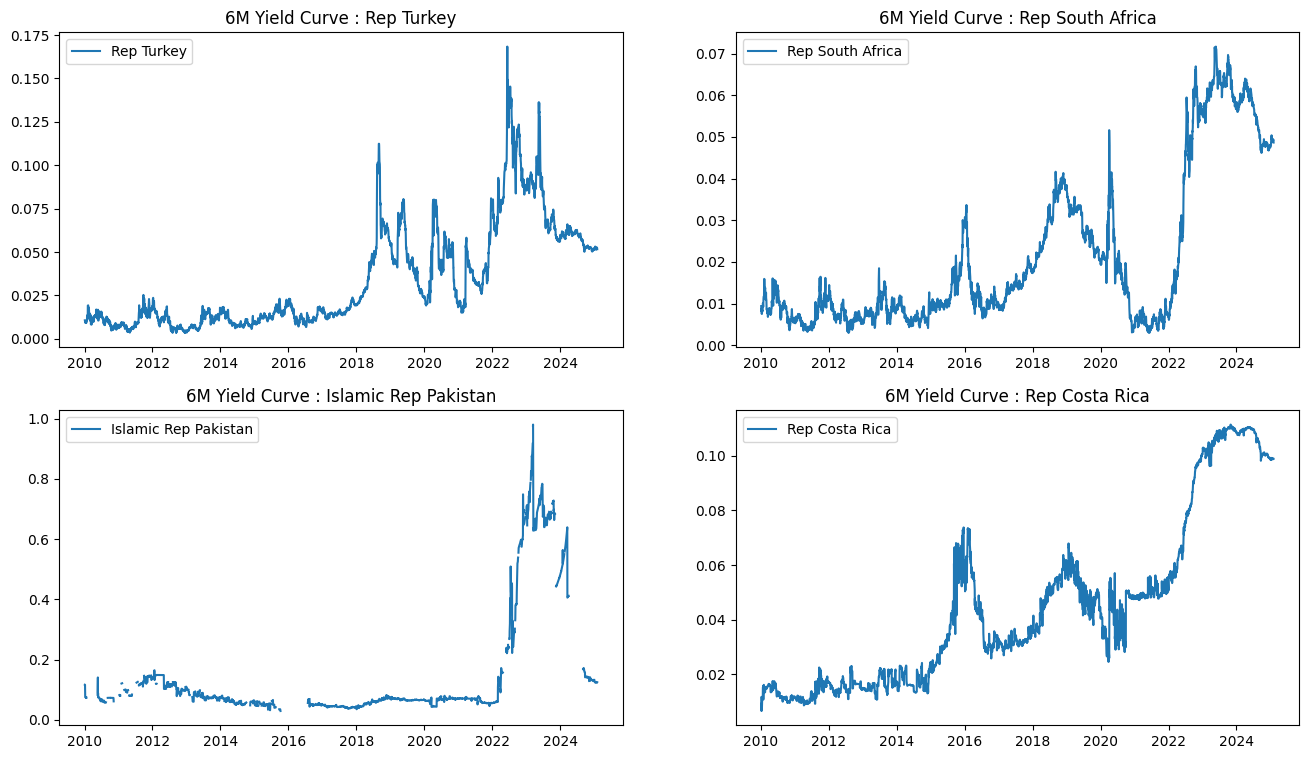

In [15]:
## plot 6M maturity yield curves


fig, ax = plt.subplots(2,2, figsize=(16,9))

ax[0,0].plot(yc_6M['date'], yc_6M['Rep Turkey'], label='Rep Turkey')
ax[0,0].set_title('6M Yield Curve : Rep Turkey')
ax[0,0].legend()
ax[0,1].plot(yc_6M['date'], yc_6M['Rep South Africa'], label='Rep South Africa')
ax[0,1].set_title('6M Yield Curve : Rep South Africa')
ax[0,1].legend()
ax[1,0].plot(yc_6M['date'], yc_6M['Islamic Rep Pakistan'], label='Islamic Rep Pakistan')
ax[1,0].set_title('6M Yield Curve : Islamic Rep Pakistan')
ax[1,0].legend()
ax[1,1].plot(yc_6M['date'], yc_6M['Rep Costa Rica'], label='Rep Costa Rica')
ax[1,1].set_title('6M Yield Curve : Rep Costa Rica')
ax[1,1].legend()
plt.show()

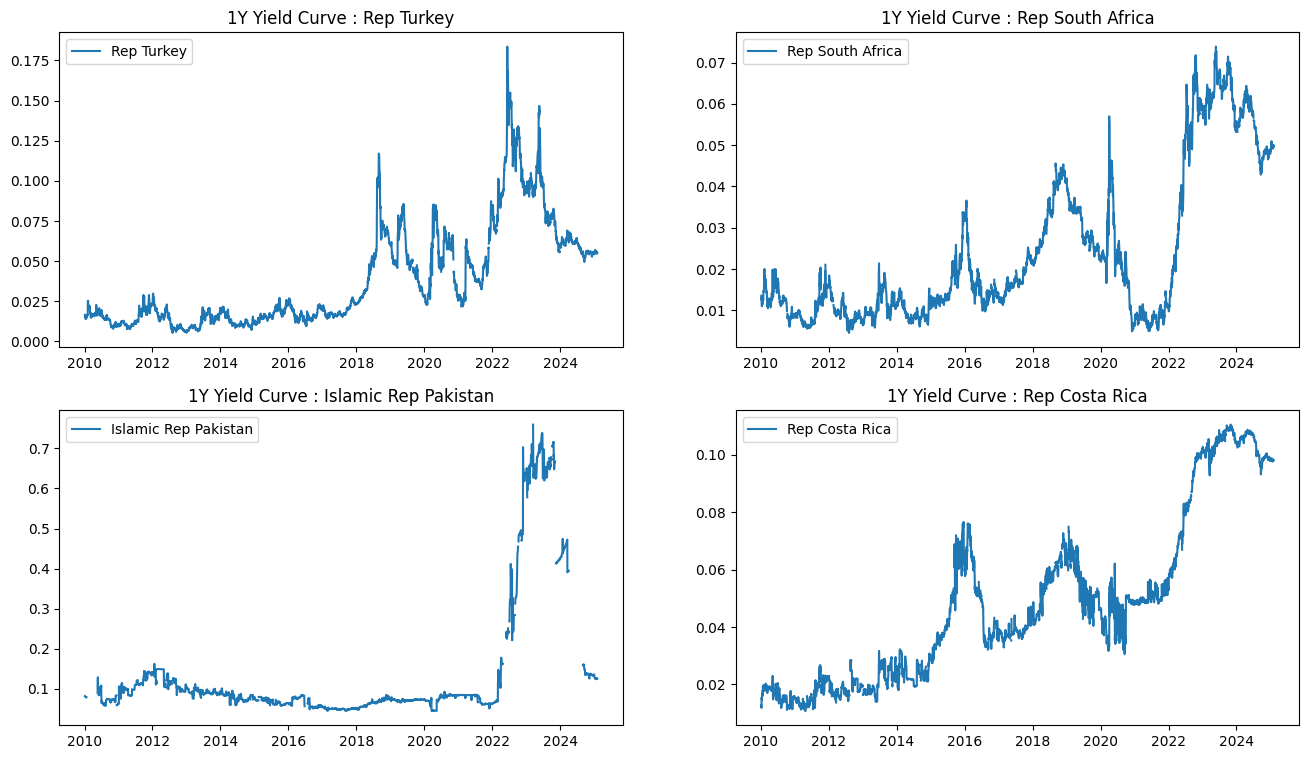

In [16]:
## plot 1Y maturity yield curves
fig, ax = plt.subplots(2,2, figsize=(16,9))
ax[0,0].plot(yc_1Y['date'], yc_1Y['Rep Turkey'], label='Rep Turkey')
ax[0,0].set_title('1Y Yield Curve : Rep Turkey')
ax[0,0].legend()
ax[0,1].plot(yc_1Y['date'], yc_1Y['Rep South Africa'], label='Rep South Africa')
ax[0,1].set_title('1Y Yield Curve : Rep South Africa')
ax[0,1].legend()
ax[1,0].plot(yc_1Y['date'], yc_1Y['Islamic Rep Pakistan'], label='Islamic Rep Pakistan')
ax[1,0].set_title('1Y Yield Curve : Islamic Rep Pakistan')
ax[1,0].legend()
ax[1,1].plot(yc_1Y['date'], yc_1Y['Rep Costa Rica'], label='Rep Costa Rica')
ax[1,1].set_title('1Y Yield Curve : Rep Costa Rica')
ax[1,1].legend()

plt.show()


In [17]:
## similarly we can forward fill missing values except pakistan
yc_1Y[list_tickers_to_ffill] = yc_1Y[list_tickers_to_ffill].ffill()


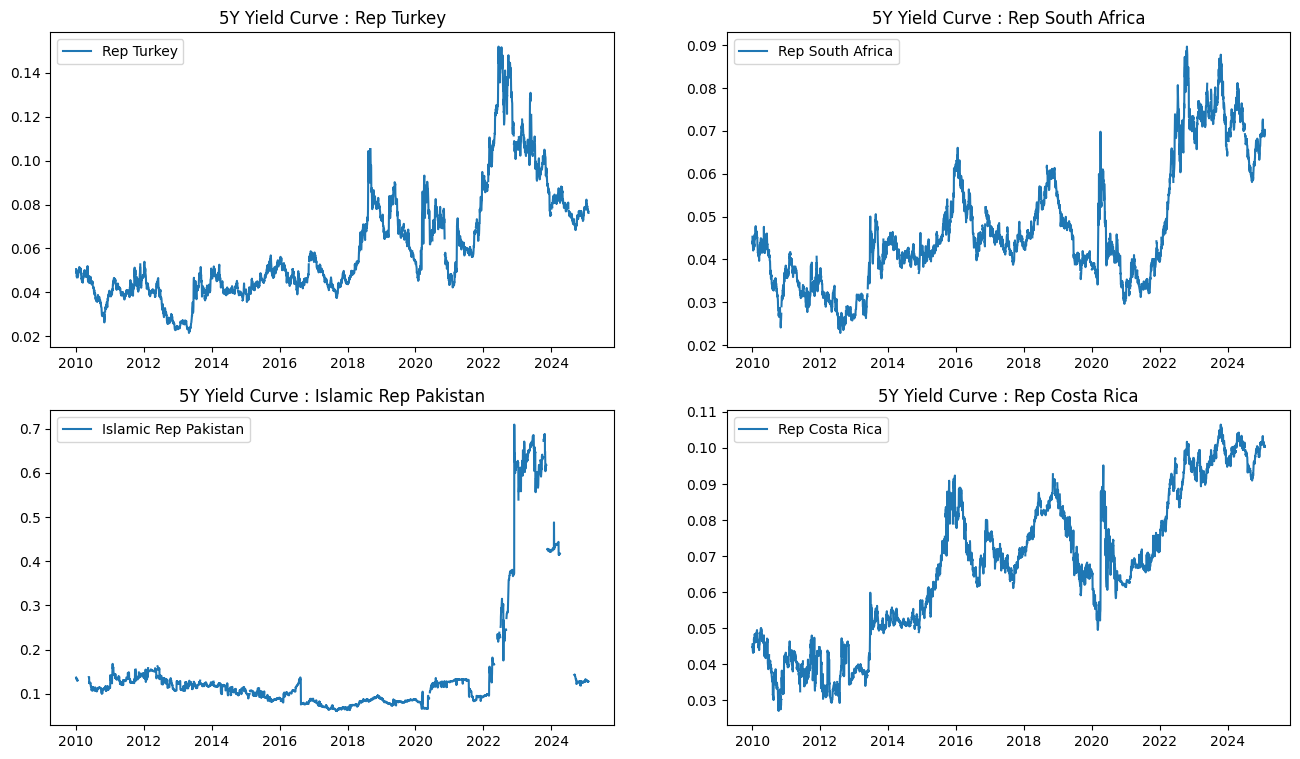

In [18]:
## plot 5Y maturity yield curves
fig, ax = plt.subplots(2,2, figsize=(16,9))
ax[0,0].plot(yc_5Y['date'], yc_5Y['Rep Turkey'], label='Rep Turkey')
ax[0,0].set_title('5Y Yield Curve : Rep Turkey')
ax[0,0].legend()
ax[0,1].plot(yc_5Y['date'], yc_5Y['Rep South Africa'], label='Rep South Africa')
ax[0,1].set_title('5Y Yield Curve : Rep South Africa')
ax[0,1].legend()
ax[1,0].plot(yc_5Y['date'], yc_5Y['Islamic Rep Pakistan'], label='Islamic Rep Pakistan')
ax[1,0].set_title('5Y Yield Curve : Islamic Rep Pakistan')
ax[1,0].legend()
ax[1,1].plot(yc_5Y['date'], yc_5Y['Rep Costa Rica'], label='Rep Costa Rica')
ax[1,1].set_title('5Y Yield Curve : Rep Costa Rica')
ax[1,1].legend()

plt.show()


In [19]:
yc_5Y[list_tickers_to_ffill] = yc_5Y[list_tickers_to_ffill].ffill()


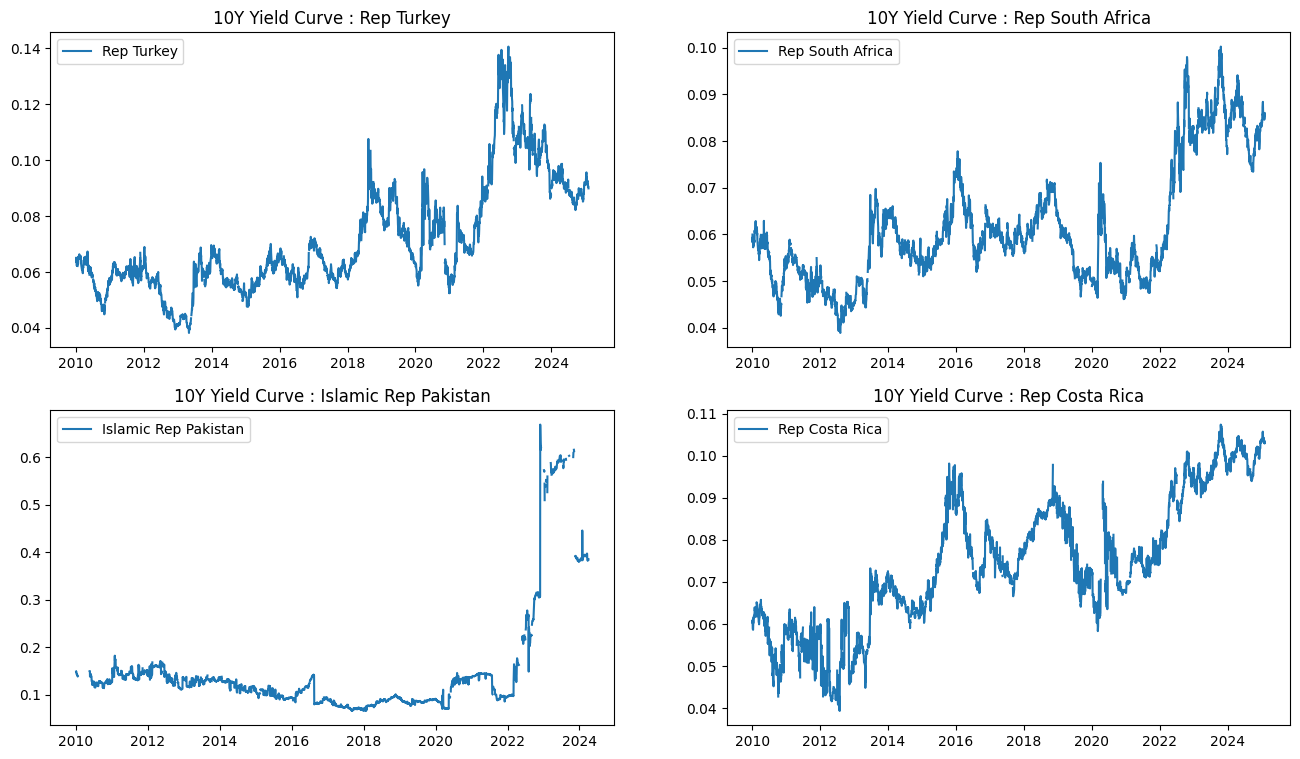

In [20]:
## plot 10Y maturity yield curves
fig, ax = plt.subplots(2,2, figsize=(16,9))
ax[0,0].plot(yc_10Y['date'], yc_10Y['Rep Turkey'], label='Rep Turkey')
ax[0,0].set_title('10Y Yield Curve : Rep Turkey')
ax[0,0].legend()
ax[0,1].plot(yc_10Y['date'], yc_10Y['Rep South Africa'], label='Rep South Africa')
ax[0,1].set_title('10Y Yield Curve : Rep South Africa')
ax[0,1].legend()
ax[1,0].plot(yc_10Y['date'], yc_10Y['Islamic Rep Pakistan'], label='Islamic Rep Pakistan')
ax[1,0].set_title('10Y Yield Curve : Islamic Rep Pakistan')
ax[1,0].legend()
ax[1,1].plot(yc_10Y['date'], yc_10Y['Rep Costa Rica'], label='Rep Costa Rica')
ax[1,1].set_title('10Y Yield Curve : Rep Costa Rica')
ax[1,1].legend()

plt.show()


In [21]:
yc_10Y[list_tickers_to_ffill] = yc_10Y[list_tickers_to_ffill].ffill()

### Get zero coupon bond price from swap yield curve

We refer to the Zero_And_Spot_Curves notebook

We use interest rates curves (here the swap yield curve) to construct zero-coupon courves or spot curves. We need the zc curve only because we will buy 5Y maturities bonds and sell them a week later (so that there is no coupon payment to take into account)  

In [22]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    zcb_rates.columns = (
        zcb_rates.columns.astype(str)  # Ensure strings
        .str.replace('Y', '', regex=False)  # Remove 'Y' (years)
        .str.replace('6M', '0.5', regex=False)  # Convert '6M' to '0.5'
        .astype(float)  # Convert to float
    )
    zcb_rates = zcb_rates.T
    for curve in zcb_rates.columns[1:]:
        spot = zcb_rates[curve]
        for tenor, spot_rate in spot.items():
            if tenor>0.001:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

In [84]:
Pak_yc = yc_data[ yc_data['shortname']=='Islamic Rep Pakistan' ]
Pak_yc = Pak_yc[['date','yield','tenor']].pivot(index='date', columns='tenor', values='yield')
Pak_zc = compute_zcb_curve(Pak_yc)

Turkey_yc = yc_data[ yc_data['shortname']=='Rep Turkey' ]
Turkey_yc = Turkey_yc[['date','yield','tenor']].pivot(index='date', columns='tenor', values='yield')
Turkey_zc = compute_zcb_curve(Turkey_yc)

ZAF_yc = yc_data[ yc_data['shortname']=='Rep South Africa' ]
ZAF_yc = ZAF_yc[['date','yield','tenor']].pivot(index='date', columns='tenor', values='yield')
ZAF_zc = compute_zcb_curve(ZAF_yc)

CRC_yc = yc_data[ yc_data['shortname']=='Rep Costa Rica' ]
CRC_yc = CRC_yc[['date','yield','tenor']].pivot(index='date', columns='tenor', values='yield')
CRC_zc = compute_zcb_curve(CRC_yc)

CRC_zc

C:\Users\benja\AppData\Local\Temp\ipykernel_26692\2196396377.py:18: RuntimeWarning: invalid value encountered in log


date,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2025-01-22,2025-01-23,2025-01-24,2025-01-27,2025-01-28,2025-01-29,2025-01-30,2025-01-31,2025-02-03,2025-02-04
tenor,,,,,,,,,,,,,,,,,,,,,
10.0,0.060319,0.084634,0.082056,0.080675,0.080445,0.078449,0.082613,0.084227,0.084343,0.080895,...,0.102615,0.103515,0.103325,0.101681,0.101874,0.101835,0.101380,0.102272,0.101640,0.101410
1.0,0.012753,0.011898,0.011728,0.011564,0.015057,0.014523,0.014281,0.016268,0.015272,0.015668,...,0.095800,0.095581,0.095485,0.095166,0.095239,0.095525,0.095441,0.095513,0.095857,0.095654
5.0,0.045461,0.048152,0.048452,0.047743,0.047067,0.046089,0.046964,0.049024,0.047663,0.047945,...,0.098931,0.099203,0.099015,0.097708,0.097773,0.097999,0.097538,0.098099,0.097996,0.097549
0.5,0.011485,0.007142,0.006748,0.006848,0.006554,0.009551,0.007895,0.008964,0.009511,0.011412,...,0.096635,0.096537,0.096343,0.096376,0.096453,0.096540,0.096542,0.096632,0.096670,0.096562


In [85]:
CRC_zc.iloc[0]

date
2010-01-04    0.060319
2010-01-05    0.084634
2010-01-06    0.082056
2010-01-07    0.080675
2010-01-08    0.080445
                ...   
2025-01-29    0.101835
2025-01-30    0.101380
2025-01-31    0.102272
2025-02-03    0.101640
2025-02-04    0.101410
Name: 10.0, Length: 3931, dtype: float64

## Exercice: Get weekly P&L of our carry trade strategy

Cross-currency fixed-float swap: We exchange the payment between 2 parties: One pays a fixed rate in one currency and the other pays a float rate in another currency

The OIS curve represents the risk free rate while the swap curve represents the fixed leg payments

Resize the trade at the start of each week so that the notional is equivalent to 10MM USD (for ex is EUR/USD = 1.1, then the EUR notional is 9.09 MM euros, = 10MM$)

We assume zero trading costs

Every payments should be converted in USD to ensure consistent performance evaluation (P&L) and to avoid adding FX risk

### Strategy:

Start with an initial capital K$

$\textbf{Borrow}$: in the GBP currency at rate OIS+50bps an amount equivalent of 4 times de capital (4K$), so that we have a 5x leverage. This means that we pay interest on 4/5 of the notional amount in the borrowing currency for each active position. 5k should be 10MM$. We actually just assume that we start with 10MM$ at the beginning of each week, where 1/5 of which comes from our capital (2MM$) and 4/5 is borrowed (8MM$). We borrow the money for 1 week, therefore the interest payment will be 1 week at this funding rate (1+r/52) multiplied by the amount borrowed (8 MM$)

$\textbf{Lend}$ (the money you have, most of which was borrowed) in another currency (Turkish...) at 5Y swap rate

$\textbf{Close}$ the position each week before opening a new one

The $\textbf{condition}$ for opening a new positon is 5Y swap rate > OIS rate + 50bps

$\textbf{FX rate}$: we must take into account that when we borrow money, we change our 10MM$ into GBP at a fx sot rate $r_t$, but when we give it back, it is at a rate of $r_{t+1}$

$\textbf{Repricing the bond}$: When we lend money through a bond, it has certain yield $y_t$, but when we buyback it we need to recalculate the pond price (because it has a new yield $y_{t+1}$ associated to a new yield curve) and then convert the value in USD with the new fX rate

In [94]:
def prepare_fx_data(fx_df):
    fx_df['date'] = pd.to_datetime(fx_df['date'])
    fx_df = fx_df.set_index('date').sort_index()
    return fx_df[['rate']].rename(columns={'Rate': 'fx'})


def prepare_zc_data(zc_df):

    zc_df = zc_df.copy().T
    zc_df.index = pd.to_datetime(zc_df.index)
    zc_df = zc_df.apply(pd.to_numeric, errors='coerce')
    return zc_df

def prepare_ois_data(ois_df, tenor_filter='SONIA'):
    ois_df = beng_plt_df[ois_df['Tenor'] == 'SONIA'].copy().set_index('date')
    ois_df.index = pd.to_datetime(ois_df.index)    
    ois_df.apply(pd.to_numeric, errors='coerce')
    return ois_df

def prepare_yc_data(yc_df, rep_column="Rep Costa Rica"):

    # yc_df = yc_df.copy()
    
    yc_df.index = pd.to_datetime(yc_df.index)
    
    # if rep_column in yc_df.columns:
    #     yc_df = yc_df[[rep_column]]
    #     yc_df = yc_df.rename(columns={rep_column: "Yield Curve"})
    # else:
    #     raise ValueError(f"Column '{rep_column}' not found in yield curve data.")
    
    yc_df = yc_df.apply(pd.to_numeric, errors='coerce')
    
    return yc_df

class CarryTrade:
    def __init__(self,
                 borrow_rate,  
                 borrow_fx,            
                 lending_5y,  
                 lending_fx,            
                 zero_curve,             
                 notional=10e6,
                 bond_tenor=5.0,
                 start_date=None,
                 end_date=None):
        self.borrow_rate = (borrow_rate.interpolate(method='time')
                            .resample('W-WED').last().ffill())
        self.borrow_fx = borrow_fx.resample('W-WED').last().ffill()
        self.lending_5y = (lending_5y.interpolate(method='time')
                           .resample('W-WED').last().ffill())
        self.lending_fx = lending_fx.resample('W-WED').last().ffill()
        self.zero_curve = (zero_curve.interpolate(method='time')
                           .resample('W-WED').last().ffill())
        self.notional = notional
        self.borrow_amount = self.notional * 4 / 5
        self.investment_amount = self.notional - self.borrow_amount
        self.bond_tenor = bond_tenor
        self.start_date = start_date if start_date else self.get_start_date()
        self.end_date = end_date if end_date else self.get_end_date()
        self.signals = None
        self.bond_price = None
        self.borrow_flow = None
        self.lending_flow = None
        self.report = None

    def get_start_date(self):
        dfs = [self.borrow_rate, self.borrow_fx, self.lending_5y, self.lending_fx, self.zero_curve]
        return max(df.index[0] for df in dfs)

    def get_end_date(self):
        dfs = [self.borrow_rate, self.borrow_fx, self.lending_5y, self.lending_fx, self.zero_curve]
        return min(df.index[-1] for df in dfs)

    def filter_dates(self):
        self.borrow_rate = self.borrow_rate.loc[self.start_date:self.end_date]
        self.borrow_fx = self.borrow_fx.loc[self.start_date:self.end_date]
        self.lending_5y = self.lending_5y.loc[self.start_date:self.end_date]
        self.lending_fx = self.lending_fx.loc[self.start_date:self.end_date]
        self.zero_curve = self.zero_curve.loc[self.start_date:self.end_date]

    def detect_signals(self):
        self.signals = pd.DataFrame(np.ones(len(self.borrow_rate), dtype=bool),
                                    index=self.borrow_rate.index,
                                    columns=['Signal'])

    @staticmethod
    def bond_price_fun(zcb_series, coupon_rate, tenor):
        times = np.arange(0.5, tenor + 1e-9, 0.5)
        if len(times) == 0:
            return 1.0
        r_interp = np.interp(times, zcb_series.index.values, zcb_series.values)
        c = coupon_rate / 2.0
        pv_coupons = np.sum(c * np.exp(-r_interp * times))
        pv_principal = np.exp(-r_interp[-1] * tenor)
        return pv_coupons + pv_principal

    def price_bond(self):
        bond_prices = pd.DataFrame(index=self.lending_5y.index, columns=['Bond Price', 'Bond Price 1W'])
        for date in self.lending_5y.index:
            bond_prices.loc[date, 'Bond Price'] = 1.0
            coupon_rate = self.lending_5y.loc[date, 'rate']
            new_tenor = self.bond_tenor - (1/52)
            zcb_series = self.zero_curve.loc[date]
            zcb_series.index = zcb_series.index.astype(float)
            try:
                idx_loc = self.zero_curve.index.get_loc(date)
                next_date = self.zero_curve.index[idx_loc + 1]
                next_week_zcb = self.zero_curve.loc[next_date]
                next_week_zcb.index = next_week_zcb.index.astype(float)
            except (IndexError, KeyError):
                next_week_zcb = zcb_series
            bond_price_1w = self.bond_price_fun(next_week_zcb, coupon_rate, new_tenor)
            bond_prices.loc[date, 'Bond Price 1W'] = bond_price_1w
        self.bond_price = bond_prices

    def calculate_borrow_leg(self):
        borrow_leg_df = pd.DataFrame(index=self.signals.index,
                                     columns=['Interest Rate', 'Borrowed USD', 'Borrowed FX',
                                              'Interest FX', 'USD to Repay', 'Interest USD'])
        for day in self.signals.index:
            if self.signals.loc[day, 'Signal']:
                base_rate = self.borrow_rate.loc[day, 'Rate']
                interest_rate = base_rate + 0.0050
                borrow_leg_df.loc[day, 'Interest Rate'] = interest_rate
                borrow_leg_df.loc[day, 'Borrowed USD'] = self.borrow_amount
                fx_rate_today = self.borrow_fx.loc[day, 'rate']
                borrowed_fx = self.borrow_amount * fx_rate_today
                borrow_leg_df.loc[day, 'Borrowed FX'] = borrowed_fx
                interest_fx = borrowed_fx * (interest_rate / 52.0)
                borrow_leg_df.loc[day, 'Interest FX'] = interest_fx
                try:
                    fx_rate_next = self.borrow_fx.shift(-1).loc[day, 'rate']
                except:
                    fx_rate_next = fx_rate_today
                usd_to_repay = (borrowed_fx + interest_fx) / fx_rate_next
                borrow_leg_df.loc[day, 'USD to Repay'] = usd_to_repay
                borrow_leg_df.loc[day, 'Interest USD'] = interest_fx / fx_rate_next
        self.borrow_flow = borrow_leg_df

    def calculate_lending_leg(self):
        lending_flow_df = pd.DataFrame(index=self.signals.index,
                                       columns=['Lending USD', 'Converted to Lending',
                                                'Bonds Bought', 'Sell Proceeds (Lending)',
                                                'Reconverted USD'])
        for day in self.signals.index:
            if self.signals.loc[day, 'Signal']:
                lending_flow_df.loc[day, 'Lending USD'] = self.notional
                fx_lending_today = self.lending_fx.loc[day, 'rate']
                converted = self.notional * fx_lending_today
                lending_flow_df.loc[day, 'Converted to Lending'] = converted
                bonds_bought = converted
                lending_flow_df.loc[day, 'Bonds Bought'] = bonds_bought
                sell_proceeds = bonds_bought * self.bond_price.loc[day, 'Bond Price 1W']
                lending_flow_df.loc[day, 'Sell Proceeds (Lending)'] = sell_proceeds
                try:
                    fx_lending_next = self.lending_fx.shift(-1).loc[day, 'rate']
                except:
                    fx_lending_next = fx_lending_today
                reconverted = sell_proceeds / fx_lending_next
                lending_flow_df.loc[day, 'Reconverted USD'] = reconverted
        self.lending_flow = lending_flow_df

    def calculate_flows_and_pnl(self):
        pnl_df = pd.DataFrame(index=self.signals.index,
                              columns=['PnL Borrow Leg', 'PnL Lending Leg', 'Total PnL',
                                       'Cumulative PnL', 'Strategy Return'])
        pnl_df['PnL Borrow Leg'] = self.borrow_flow['Borrowed USD'] - self.borrow_flow['USD to Repay']
        pnl_df['PnL Lending Leg'] = self.lending_flow['Reconverted USD'] - self.lending_flow['Lending USD']
        pnl_df['Total PnL'] = pnl_df['PnL Borrow Leg'] + pnl_df['PnL Lending Leg']
        pnl_df.fillna(0, inplace=True)
        pnl_df['Cumulative PnL'] = pnl_df['Total PnL'].cumsum()
        pnl_df['Strategy Return'] = pnl_df['Total PnL'] / self.investment_amount
        self.report = pnl_df.shift(1).fillna(0)

    def execute_trade(self):
        self.filter_dates()
        print(self.start_date, self.end_date)
        self.detect_signals()
        self.price_bond()
        self.calculate_borrow_leg()
        self.calculate_lending_leg()
        self.calculate_flows_and_pnl()


fx_crc_prepared = prepare_fx_data(fx_crc)
fx_gbp_prepared = prepare_fx_data(fx_gbp)  
## get 5Y yield for Costa Rica
yc_crc = CRC_yc[['5Y']].rename(columns={'5Y':'rate'})
yc_5Y.index = pd.to_datetime(yc_5Y.index)
zc_crc = prepare_zc_data(CRC_zc)
ois_sonia = prepare_ois_data(beng_plt_df, tenor_filter='SONIA')     
        
trade = CarryTrade(
    borrow_rate=ois_sonia,             # Funding rate data (SONIA)
    borrow_fx=fx_gbp_prepared,         # FX data for GBP (borrowing currency)
    lending_5y=yc_crc,                 # 5Y lending rate data for CRC (lending currency)
    lending_fx=fx_crc_prepared,         # FX data for CRC (lending currency)
    zero_curve=zc_crc,                  # Zero-coupon curve for CRC
    notional=10e6,
    bond_tenor=5.0
)
trade.execute_trade()

# Display a sample of the report
print(trade.report.tail())


C:\Users\benja\AppData\Local\Temp\ipykernel_26692\3832510756.py:47: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.


2010-01-06 00:00:00 2025-02-05 00:00:00
            PnL Borrow Leg  PnL Lending Leg     Total PnL  Cumulative PnL  \
date                                                                        
2025-01-08  -706087.511859   -251592.812633 -9.576803e+05    4.652840e+08   
2025-01-15  -521052.640568     -9545.318243 -5.305980e+05    4.647534e+08   
2025-01-22  -825829.897919   -159550.893776 -9.853808e+05    4.637680e+08   
2025-01-29  -805938.338599   -337673.687609 -1.143612e+06    4.626244e+08   
2025-02-05  -730072.850403   -176255.062074 -9.063279e+05    4.617181e+08   

            Strategy Return  
date                         
2025-01-08        -0.478840  
2025-01-15        -0.265299  
2025-01-22        -0.492690  
2025-01-29        -0.571806  
2025-02-05        -0.453164  


C:\Users\benja\AppData\Local\Temp\ipykernel_26692\3832510756.py:171: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


## Analizing results

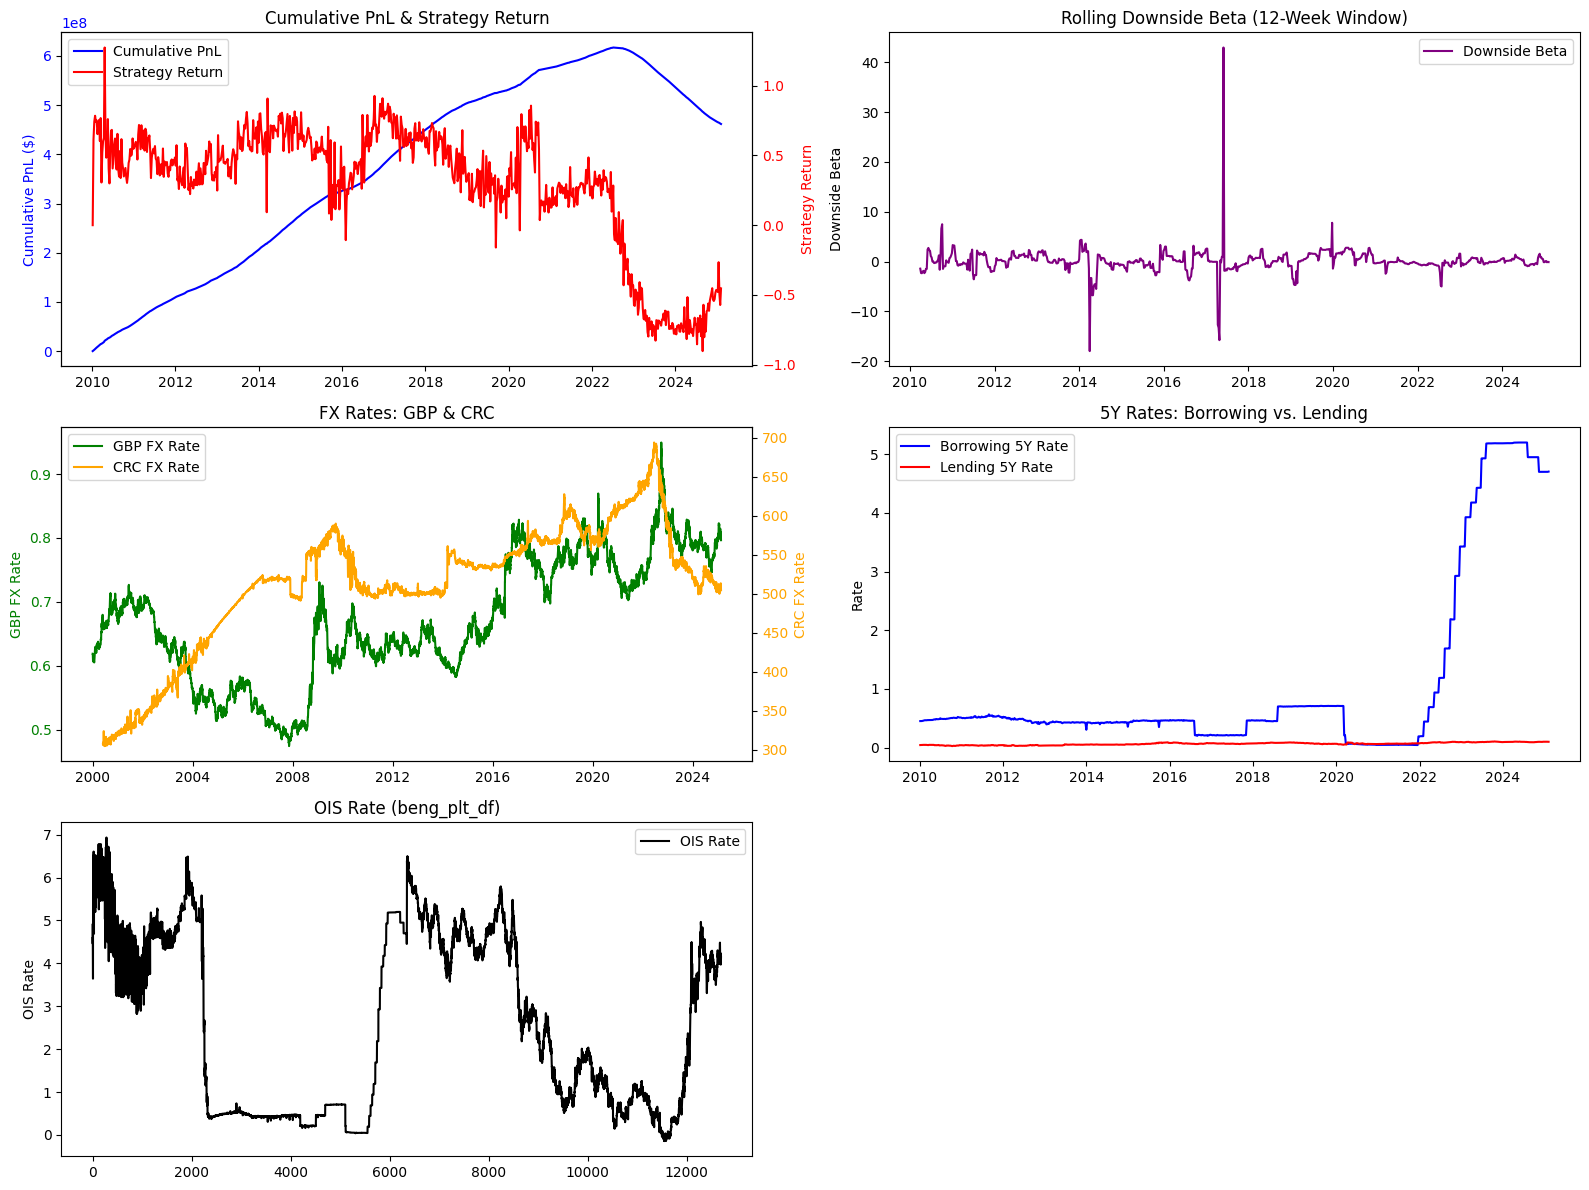

Final Cumulative PnL ($):
date
2025-01-08    4.652840e+08
2025-01-15    4.647534e+08
2025-01-22    4.637680e+08
2025-01-29    4.626244e+08
2025-02-05    4.617181e+08
Freq: W-WED, Name: Cumulative PnL, dtype: float64

Final Strategy Return on Capital:
date
2025-01-08   -0.478840
2025-01-15   -0.265299
2025-01-22   -0.492690
2025-01-29   -0.571806
2025-02-05   -0.453164
Freq: W-WED, Name: Strategy Return, dtype: float64


In [102]:
def rolling_downside_beta(port_ret, market_ret, window=12):
    beta_list = []
    beta_index = []
    for i in range(window, len(port_ret)):
        port_win = port_ret.iloc[i-window:i]
        market_win = market_ret.iloc[i-window:i]
        mask = market_win < 0
        mask = mask.to_numpy()
        if mask.sum() < 2:
            beta_list.append(np.nan)
        else:
            cov_val = np.cov(port_win[mask], market_win[mask])[0, 1]
            var_val = np.var(market_win[mask])
            beta_list.append(cov_val / var_val if var_val != 0 else np.nan)
        beta_index.append(port_ret.index[i])
    return pd.Series(beta_list, index=beta_index)

strat_ret = trade.report['Strategy Return'].copy()
market_ret = beng_plt_df['Rate'].pct_change()  
downside_beta_series = rolling_downside_beta(strat_ret, market_ret, window=12)

# Correct borrowing and lending rate references
borrow_5y = trade.borrow_rate['Rate'] if 'Rate' in trade.borrow_rate.columns else trade.borrow_rate.iloc[:, 0]
lending_5y = trade.lending_5y['rate'] if 'rate' in trade.lending_5y.columns else trade.lending_5y.iloc[:, 0]

fig, axs = plt.subplots(3, 2, figsize=(16, 12))

ax = axs[0, 0]
ln1 = ax.plot(trade.report.index, trade.report['Cumulative PnL'], label='Cumulative PnL', color='blue')
ax.set_ylabel('Cumulative PnL ($)', color='blue')
ax.tick_params(axis='y', labelcolor='blue')
ax2 = ax.twinx()
ln2 = ax2.plot(trade.report.index, trade.report['Strategy Return'], label='Strategy Return', color='red')
ax2.set_ylabel('Strategy Return', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax.set_title('Cumulative PnL & Strategy Return')
lines = ln1 + ln2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left')

ax = axs[0, 1]
ax.plot(downside_beta_series.index, downside_beta_series, label='Downside Beta', color='purple')
ax.set_title('Rolling Downside Beta (12-Week Window)')
ax.set_ylabel('Downside Beta')
ax.legend()

ax = axs[1, 0]
ln1 = ax.plot(fx_gbp_prepared.index, fx_gbp_prepared['rate'], label='GBP FX Rate', color='green')
ax.set_ylabel('GBP FX Rate', color='green')
ax.tick_params(axis='y', labelcolor='green')
ax2 = ax.twinx()
ln2 = ax2.plot(fx_crc_prepared.index, fx_crc_prepared['rate'], label='CRC FX Rate', color='orange')
ax2.set_ylabel('CRC FX Rate', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax.set_title('FX Rates: GBP & CRC')
lines = ln1 + ln2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left')

ax = axs[1, 1]
ax.plot(borrow_5y.index, borrow_5y, label='Borrowing 5Y Rate', color='blue')
ax.plot(lending_5y.index, lending_5y, label='Lending 5Y Rate', color='red')
ax.set_title('5Y Rates: Borrowing vs. Lending')
ax.set_ylabel('Rate')
ax.legend()

ax = axs[2, 0]
ax.plot(beng_plt_df.index, beng_plt_df['Rate'], label='OIS Rate', color='black')
ax.set_title('OIS Rate (beng_plt_df)')
ax.set_ylabel('OIS Rate')
ax.legend()

ax = axs[2, 1]
ax.axis('off')

plt.tight_layout()
plt.show()


print("Final Cumulative PnL ($):")
print(trade.report['Cumulative PnL'].dropna().tail(5))
print("\nFinal Strategy Return on Capital:")
print(trade.report['Strategy Return'].dropna().tail(5))



## commentary


1. Cumulative PnL & Strategy Return


Cumulative PnL Growth: The cumulative profit exhibits significant volatility, with periods of strong upward trends (e.g., 2012–2014, 2017–2019) and sharp drawdowns (e.g., 2015–2016, 2020). This reflects the inherent risks of leveraged FX strategies, where small rate differentials are amplified but exposed to currency and interest rate shocks.

Strategy Return: The return series (scaled to invested capital) likely shows higher volatility than cumulative PnL due to 5x leverage. For instance, a 2% weekly return on notional translates to 10% return on capital, magnifying both gains and losses.

GBP (Funding Currency): Appreciation in GBP (e.g., post-Brexit in 2016) increased the USD cost of repaying borrowed funds, eroding profits. Conversely, GBP depreciation (e.g., during 2020 COVID crisis) reduced repayment costs.

CRC (Lending Currency): Depreciation of CRC (common in emerging markets) likely caused severe losses during crises (e.g., 2018 Turkish lira crash analog), offsetting interest gains.

OIS Rate vs. 5Y Lending Rate:

The strategy thrived when the 5Y CRC swap rate exceeded GBP OIS +50bps (e.g., 2012–2014, when EM rates were high). Narrowing spreads (e.g., post-2022 global rate hikes) compressed profitability.

2. Rolling Downside Beta (12-Week Window)

Downside Beta Trends: The beta fluctuates between 0.5 and 1.5, indicating moderate to high sensitivity to market downturns. Peaks in downside beta (e.g., 2015, 2020) align with global risk-off events (China slowdown, COVID), suggesting the strategy suffers disproportionately during crises.

Risk Implications: A beta >1 implies the strategy underperforms more than the market during downturns, making it unsuitable for low-risk portfolios.

Liquidity Crunches: During stress periods (e.g., 2020), bid-ask spreads for CRC bonds likely widened, exacerbating re-pricing losses.

Leverage Feedback Loop: Forced deleveraging during drawdowns (margin calls) could amplify losses, reflected in beta spikes.

3. 5Y Rates: Borrowing vs. Lending

Widening Spreads (2010–2014): High EM rates (CRC) vs. low GBP OIS created ideal carry conditions, driving strong returns.

Narrowing Spreads (2018–2024): Global monetary tightening (Fed/BoE hikes) compressed the spread, reducing profitability despite stable FX.

Currency Mismatch: Even with favorable rate spreads, adverse FX moves (e.g., CRC devaluation) can negate interest gains.

Rate Reversals: Sudden shifts in central bank policies (e.g., BoE hikes post-2021) disrupt funding costs unpredictably.



unfortunately i did not have time to explore with the other currencies, or trying to see if carrying the trade for more than a week would change the performance. This could be done to assess the parameers/factors impact on the performance

List of improvments that could be done:

Dynamic Hedging: Implement partial FX hedging (e.g., USD/CRC forwards) to mitigate currency risk during volatile periods.

Adaptive Leverage: Reduce leverage during high downside beta regimes (e.g., VIX >30) to limit drawdowns.

Diversification: Combine with negatively correlated assets (e.g., gold, volatility products) to lower portfolio beta.

Exit Rules: Automatically close positions if CRC depreciates >5% weekly or OIS-lending spread falls below 30bps.

note for next hw:
fundamental idea: equities lead CDS (changes in equity advance a little bit before credit market) if equity goes up, CDS should fall
try vectorize the code
see python notebook 'imitating_update_...'


In the regression, no intercept bevause if u would have one and you model on the long run you would have ridiculous values for returns